<a href="https://www.kaggle.com/code/yang25/ml-tp2?scriptVersionId=274203639" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Step 1: Baseline with Logistic Regression

In [2]:
# 1. 导入必要的库
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import log_loss, classification_report, confusion_matrix
import string

# 2. 加载数据
train = pd.read_csv('/kaggle/input/llm-classification-finetuning/train.csv')
test = pd.read_csv('/kaggle/input/llm-classification-finetuning/test.csv')

# 3. 特征工程：提取统计特征

def create_features(df):
    # 长度特征
    df['prompt_length'] = df['prompt'].str.len()
    df['response_a_length'] = df['response_a'].str.len()
    df['response_b_length'] = df['response_b'].str.len()
    # 单词数
    df['prompt_word_count'] = df['prompt'].str.split().str.len()
    df['response_a_word_count'] = df['response_a'].str.split().str.len()
    df['response_b_word_count'] = df['response_b'].str.split().str.len()
    # 标点数
    df['prompt_punc_count'] = df['prompt'].str.count(f'[{string.punctuation}]')
    df['response_a_punc_count'] = df['response_a'].str.count(f'[{string.punctuation}]')
    df['response_b_punc_count'] = df['response_b'].str.count(f'[{string.punctuation}]')
    # 差异特征
    df['response_length_diff'] = df['response_a_length'] - df['response_b_length']
    df['response_word_diff'] = df['response_a_word_count'] - df['response_b_word_count']
    return df

train = create_features(train)
test = create_features(test)

# 4. Label编码（可选：对model名称，但test不会用到）
le = LabelEncoder()
model_cols = []
for col in ['model_a', 'model_b']:
    train[f'{col}_enc'] = le.fit_transform(train[col])
    model_cols += [f'{col}_enc']

# 5. 构造标签
#   winner_model_a=1→类别0，winner_model_b=1→类别1，winner_tie=1→类别2
train['target'] = train[['winner_model_a', 'winner_model_b', 'winner_tie']].values.argmax(axis=1)

# 6. 选定全部数值特征
feature_cols = [
    'prompt_length', 'response_a_length', 'response_b_length',
    'prompt_word_count', 'response_a_word_count', 'response_b_word_count',
    'prompt_punc_count', 'response_a_punc_count', 'response_b_punc_count',
    'response_length_diff', 'response_word_diff'
    # 若希望，也可添加model_a_enc/model_b_enc
]

X = train[feature_cols]
y = train['target']

# 7. 数据拆分 + 标准化
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 8. 逻辑回归训练
clf = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
clf.fit(X_train_scaled, y_train)

# 9. 验证集效果
val_pred_proba = clf.predict_proba(X_val_scaled)
val_pred = clf.predict(X_val_scaled)
print('Validation Log Loss:', log_loss(y_val, val_pred_proba))
print('Classification Report:\n', classification_report(y_val, val_pred, digits=4))

# 10. 生成test特征、标准化并预测
X_test = test[feature_cols]
X_test_scaled = scaler.transform(X_test)
test_pred_proba = clf.predict_proba(X_test_scaled)

# 11. 生成Kaggle提交文件
submission = pd.DataFrame({
    'id': test['id'],
    'winner_model_a': test_pred_proba[:,0],
    'winner_model_b': test_pred_proba[:,1],
    'winner_tie': test_pred_proba[:,2],
})
submission.to_csv('submission_baseline.csv', index=False)
print(submission.head())


Validation Log Loss: 1.0693143435673163
Classification Report:
               precision    recall  f1-score   support

           0     0.4299    0.6272    0.5101      4013
           1     0.4427    0.5838    0.5036      3931
           2     0.4333    0.0557    0.0988      3552

    accuracy                         0.4358     11496
   macro avg     0.4353    0.4223    0.3708     11496
weighted avg     0.4353    0.4358    0.3808     11496

        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.326506        0.339918    0.333576
1   211333        0.430541        0.252233    0.317226
2  1233961        0.431887        0.307438    0.260675


In [3]:
#Step 2: Embedding-based model

In [4]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

train = pd.read_csv('/kaggle/input/llm-classification-finetuning/train.csv')
test = pd.read_csv('/kaggle/input/llm-classification-finetuning/test.csv')

# 用本地模型路径加载（路径需和你 Add Input 名称一致）
model = SentenceTransformer('/kaggle/input/minilm-l12-v2-local/other/default/1/minilm_l12_v2_local')

# 拼接文本
def concat_text(df):
    return (
        df['prompt'].astype(str) + ' ' + df['response_a'].astype(str),
        df['prompt'].astype(str) + ' ' + df['response_b'].astype(str)
    )
train_a, train_b = concat_text(train)
test_a, test_b = concat_text(test)

emb_a = model.encode(train_a.tolist(), batch_size=32, show_progress_bar=True)
emb_b = model.encode(train_b.tolist(), batch_size=32, show_progress_bar=True)
X = np.hstack([emb_a, emb_b, emb_a - emb_b])
y = train[['winner_model_a','winner_model_b','winner_tie']].values.argmax(axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
print('Val Log Loss:', log_loss(y_val, clf.predict_proba(X_val)))

emb_a_test = model.encode(test_a.tolist(), batch_size=32, show_progress_bar=True)
emb_b_test = model.encode(test_b.tolist(), batch_size=32, show_progress_bar=True)
X_test = np.hstack([emb_a_test, emb_b_test, emb_a_test - emb_b_test])
proba = clf.predict_proba(X_test)

submission = pd.DataFrame({
    'id': test['id'],
    'winner_model_a': proba[:,0],
    'winner_model_b': proba[:,1],
    'winner_tie': proba[:,2]
})
submission.to_csv('submission_emb.csv', index=False)


2025-11-07 09:36:06.227674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762508166.450759      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762508166.517519      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `ty

Batches:   0%|          | 0/1797 [00:00<?, ?it/s]

Batches:   0%|          | 0/1797 [00:00<?, ?it/s]

Val Log Loss: 1.0668766656893598


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
#Step 3. Model Extensions

In [6]:
print("Starting Step 3: Model Extensions...")

# 安装必要的库（如果尚未安装）
!pip install xgboost lightgbm --quiet

# 导入所有必要的库
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sentence_transformers import SentenceTransformer
import re
import warnings
warnings.filterwarnings('ignore')

print("所有库导入完成")

# 加载数据
print("加载数据...")
train = pd.read_csv('/kaggle/input/llm-classification-finetuning/train.csv')
test = pd.read_csv('/kaggle/input/llm-classification-finetuning/test.csv')

print(f"训练集大小: {train.shape}")
print(f"测试集大小: {test.shape}")

# =============================================================================
# 1. 偏差感知特征工程 (Bias-aware Features)
# =============================================================================

def extract_bias_aware_features(df):
    """
    提取位置偏差和冗长偏差相关特征
    """
    print("提取偏差感知特征...")
    features = pd.DataFrame(index=df.index)
    
    # 位置偏差特征 (Position Bias)
    features['position_a_first'] = 1  # response_a总是第一个
    features['position_b_second'] = 0
    
    # 冗长偏差特征 (Verbosity Bias)
    features['response_a_length'] = df['response_a'].str.len()
    features['response_b_length'] = df['response_b'].str.len()
    features['length_diff'] = features['response_a_length'] - features['response_b_length']
    features['length_ratio'] = features['response_a_length'] / (features['response_b_length'] + 1)
    
    # 词汇丰富度特征
    def lexical_richness(text):
        if pd.isna(text) or text == '':
            return 0
        words = str(text).split()
        if len(words) == 0:
            return 0
        return len(set(words)) / len(words)
    
    features['richness_a'] = df['response_a'].apply(lexical_richness)
    features['richness_b'] = df['response_b'].apply(lexical_richness)
    features['richness_diff'] = features['richness_a'] - features['richness_b']
    
    # 格式特征 (检查是否有列表、代码块等)
    def format_complexity(text):
        score = 0
        text_str = str(text)
        # 检查列表
        if re.search(r'\d+\.|\*|\-', text_str):
            score += 1
        # 检查代码块
        if '```' in text_str or '    ' in text_str:
            score += 1
        # 检查标题
        if re.search(r'^#+\s', text_str, re.MULTILINE):
            score += 1
        return score
    
    features['format_a'] = df['response_a'].apply(format_complexity)
    features['format_b'] = df['response_b'].apply(format_complexity)
    features['format_diff'] = features['format_a'] - features['format_b']
    
    # 问号和感叹号数量特征
    features['question_a'] = df['response_a'].str.count(r'\?')
    features['question_b'] = df['response_b'].str.count(r'\?')
    features['exclamation_a'] = df['response_a'].str.count(r'!')
    features['exclamation_b'] = df['response_b'].str.count(r'!')
    
    features['question_diff'] = features['question_a'] - features['question_b']
    features['exclamation_diff'] = features['exclamation_a'] - features['exclamation_b']
    
    print(f"偏差特征提取完成，特征数量: {features.shape[1]}")
    return features

# 提取偏差特征
bias_features_train = extract_bias_aware_features(train)
bias_features_test = extract_bias_aware_features(test)

# =============================================================================
# 2. 基础统计特征 (Basic Statistical Features)
# =============================================================================

def extract_basic_features(df):
    """
    提取基础统计特征（类似Step 1但更全面）
    """
    print("提取基础统计特征...")
    features = pd.DataFrame(index=df.index)
    
    # 长度特征
    features['prompt_length'] = df['prompt'].str.len()
    features['response_a_length'] = df['response_a'].str.len()
    features['response_b_length'] = df['response_b'].str.len()
    
    # 单词数量
    features['prompt_word_count'] = df['prompt'].str.split().str.len()
    features['response_a_word_count'] = df['response_a'].str.split().str.len()
    features['response_b_word_count'] = df['response_b'].str.split().str.len()
    
    # 标点符号数量
    import string
    features['prompt_punc_count'] = df['prompt'].str.count(f'[{re.escape(string.punctuation)}]')
    features['response_a_punc_count'] = df['response_a'].str.count(f'[{re.escape(string.punctuation)}]')
    features['response_b_punc_count'] = df['response_b'].str.count(f'[{re.escape(string.punctuation)}]')
    
    # 差异特征
    features['response_length_diff'] = features['response_a_length'] - features['response_b_length']
    features['response_word_diff'] = features['response_a_word_count'] - features['response_b_word_count']
    features['response_punc_diff'] = features['response_a_punc_count'] - features['response_b_punc_count']
    
    print(f"基础特征提取完成，特征数量: {features.shape[1]}")
    return features

# 提取基础特征
basic_features_train = extract_basic_features(train)
basic_features_test = extract_basic_features(test)

# =============================================================================
# 3. 嵌入特征 (Embedding Features)
# =============================================================================

print("加载嵌入模型...")
# 使用小组已有的预训练模型
try:
    model = SentenceTransformer('/kaggle/input/minilm-l12-v2-local/other/default/1/minilm_l12_v2_local')
    print("使用本地预训练模型")
except:
    # 如果本地模型不可用，使用在线模型
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    print("使用在线预训练模型")

def create_embedding_features(df, model):
    """
    创建嵌入特征
    """
    print("生成嵌入特征...")
    
    # 文本拼接
    def concat_text(df):
        return (
            df['prompt'].astype(str) + ' [SEP] ' + df['response_a'].astype(str),
            df['prompt'].astype(str) + ' [SEP] ' + df['response_b'].astype(str)
        )
    
    text_a, text_b = concat_text(df)
    
    # 获取嵌入特征
    emb_a = model.encode(text_a.tolist(), batch_size=32, show_progress_bar=True)
    emb_b = model.encode(text_b.tolist(), batch_size=32, show_progress_bar=True)
    
    # 嵌入特征工程
    embedding_features = np.hstack([
        emb_a, 
        emb_b, 
        emb_a - emb_b,  # 差异特征
        np.abs(emb_a - emb_b),  # 绝对差异
        emb_a * emb_b,  # 交互特征
    ])
    
    print(f"嵌入特征生成完成，特征维度: {embedding_features.shape}")
    return embedding_features

# 创建嵌入特征
print("为训练集创建嵌入特征...")
embedding_features_train = create_embedding_features(train, model)
print("为测试集创建嵌入特征...")
embedding_features_test = create_embedding_features(test, model)

# =============================================================================
# 4. 合并所有特征
# =============================================================================

print("合并所有特征...")
X_ensemble = np.hstack([
    embedding_features_train,
    bias_features_train.values,
    basic_features_train.values
])

X_test_ensemble = np.hstack([
    embedding_features_test,
    bias_features_test.values,
    basic_features_test.values
])

# 目标变量
y = train[['winner_model_a', 'winner_model_b', 'winner_tie']].values.argmax(axis=1)

print(f"最终特征矩阵大小: {X_ensemble.shape}")
print(f"测试集特征矩阵大小: {X_test_ensemble.shape}")

# =============================================================================
# 5. 数据准备
# =============================================================================

print("准备训练和验证数据...")
X_train, X_val, y_train, y_val = train_test_split(
    X_ensemble, y, test_size=0.2, random_state=42, stratify=y
)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_ensemble)

print("数据准备完成")

# =============================================================================
# 6. 训练多个基础模型
# =============================================================================

print("训练多个基础模型...")

# 基础模型集合
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss',
        n_jobs=-1
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
}

# 单独训练每个模型并评估
base_model_predictions = {}
base_model_scores = {}

for name, model in models.items():
    print(f"训练 {name}...")
    model.fit(X_train_scaled, y_train)
    
    # 验证集预测
    val_pred_proba = model.predict_proba(X_val_scaled)
    val_score = log_loss(y_val, val_pred_proba)
    
    base_model_predictions[name] = val_pred_proba
    base_model_scores[name] = val_score
    print(f"  {name} 验证集 Log Loss: {val_score:.4f}")

# =============================================================================
# 7. 集成方法
# =============================================================================

print("\n训练集成模型...")

# 7.1 投票集成 (Voting Ensemble)
print("训练投票集成模型...")
voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train)
voting_pred_proba = voting_clf.predict_proba(X_val_scaled)
voting_score = log_loss(y_val, voting_pred_proba)
print(f"投票集成验证集 Log Loss: {voting_score:.4f}")

# 7.2 概率校准 (Probability Calibration)
print("进行概率校准...")
# 选择性能最好的基础模型进行校准
best_base_model_name = min(base_model_scores, key=base_model_scores.get)
print(f"选择 {best_base_model_name} 进行概率校准")

calibrated_clf = CalibratedClassifierCV(
    models[best_base_model_name], 
    method='isotonic', 
    cv=3
)
calibrated_clf.fit(X_train_scaled, y_train)
calibrated_pred_proba = calibrated_clf.predict_proba(X_val_scaled)
calibrated_score = log_loss(y_val, calibrated_pred_proba)
print(f"校准后验证集 Log Loss: {calibrated_score:.4f}")

# 7.3 加权平均集成 (Weighted Average Ensemble)
print("进行加权平均集成...")
# 基于验证集性能计算权重（性能越好权重越高）
weights = {}
total_performance = sum(1/score for score in base_model_scores.values())
for name, score in base_model_scores.items():
    weights[name] = (1/score) / total_performance

print("模型权重分配:")
for name, weight in weights.items():
    print(f"  {name}: {weight:.3f}")

def weighted_average_predict(models, weights, X):
    """加权平均预测"""
    predictions = []
    for name, model in models.items():
        pred = model.predict_proba(X)
        weighted_pred = pred * weights[name]
        predictions.append(weighted_pred)
    
    # 平均预测
    final_pred = np.mean(predictions, axis=0)
    return final_pred

weighted_pred_proba = weighted_average_predict(models, weights, X_val_scaled)
weighted_score = log_loss(y_val, weighted_pred_proba)
print(f"加权平均集成验证集 Log Loss: {weighted_score:.4f}")

# =============================================================================
# 8. 模型性能比较和选择
# =============================================================================

print("\n" + "="*50)
print("模型性能比较")
print("="*50)

# 收集所有模型性能
all_scores = {
    **base_model_scores,
    'Voting Ensemble': voting_score,
    'Calibrated Model': calibrated_score,
    'Weighted Average': weighted_score
}

# 按性能排序
sorted_scores = sorted(all_scores.items(), key=lambda x: x[1])

print("\n模型性能排名:")
print("-" * 40)
for name, score in sorted_scores:
    print(f"{name:20} | Log Loss: {score:.4f}")

# 选择最佳模型
best_model_name, best_score = sorted_scores[0]
print(f"\n最佳模型: {best_model_name}")
print(f"最佳分数: {best_score:.4f}")

# =============================================================================
# 9. 使用最佳模型进行最终预测
# =============================================================================

print(f"\n使用 {best_model_name} 进行最终预测...")

if best_model_name == 'Voting Ensemble':
    final_model = voting_clf
    # 在所有数据上重新训练
    X_all_scaled = scaler.fit_transform(X_ensemble)
    final_model.fit(X_all_scaled, y)
    final_predictions = final_model.predict_proba(X_test_scaled)
    
elif best_model_name == 'Calibrated Model':
    final_model = calibrated_clf
    # 注意：CalibratedClassifierCV已经使用了交叉验证，不需要重新训练
    final_predictions = final_model.predict_proba(X_test_scaled)
    
elif best_model_name == 'Weighted Average':
    # 对于加权平均，在所有数据上重新训练基础模型
    print("在所有数据上重新训练基础模型用于加权平均...")
    for name, model in models.items():
        X_all_scaled = scaler.fit_transform(X_ensemble)
        model.fit(X_all_scaled, y)
    final_predictions = weighted_average_predict(models, weights, X_test_scaled)
    
else:
    # 单个基础模型
    final_model = models[best_model_name]
    X_all_scaled = scaler.fit_transform(X_ensemble)
    final_model.fit(X_all_scaled, y)
    final_predictions = final_model.predict_proba(X_test_scaled)

# =============================================================================
# 10. 生成提交文件
# =============================================================================

print("生成提交文件...")
submission = pd.DataFrame({
    'id': test['id'],
    'winner_model_a': final_predictions[:, 0],
    'winner_model_b': final_predictions[:, 1],
    'winner_tie': final_predictions[:, 2],
})

submission.to_csv('submission_advanced_ensemble.csv', index=False)
print("高级集成模型提交文件已生成: submission_advanced_ensemble.csv")

print("\n提交文件预览:")
print(submission.head())

# =============================================================================
# 11. 误差分析 (修复后的版本)
# =============================================================================

print("\n" + "="*50)
print("误差分析")
print("="*50)

# 使用最佳模型在验证集上的预测进行分析
if best_model_name == 'Weighted Average':
    val_predictions_final = weighted_average_predict(models, weights, X_val_scaled)
else:
    val_predictions_final = final_model.predict_proba(X_val_scaled)

val_pred_labels = np.argmax(val_predictions_final, axis=1)

# 计算每个类别的log loss (修复：添加labels参数)
class_names = ['model_a', 'model_b', 'tie']
print("\n各类别Log Loss分析:")
for class_idx in range(3):
    class_mask = (y_val == class_idx)
    if np.sum(class_mask) > 0:
        # 修复：添加labels参数，明确指定所有可能的类别
        class_loss = log_loss(y_val[class_mask], val_predictions_final[class_mask], labels=[0, 1, 2])
        print(f"  类别 {class_names[class_idx]}: {class_loss:.4f}")
    else:
        print(f"  类别 {class_names[class_idx]}: 无样本")

# 混淆矩阵
cm = confusion_matrix(y_val, val_pred_labels)
print(f"\n混淆矩阵:")
print(cm)

# 准确率
accuracy = np.mean(y_val == val_pred_labels)
print(f"\n验证集准确率: {accuracy:.4f}")

# =============================================================================
# 12. 与基线模型比较
# =============================================================================

print("\n" + "="*50)
print("Step 3 完成总结")
print("="*50)

print("Step 3 高级集成模型完成!")
print(f"最佳模型: {best_model_name}")
print(f"验证集Log Loss: {best_score:.4f}")
print(f"验证集准确率: {accuracy:.4f}")
print("提交文件: submission_advanced_ensemble.csv")

print("\n请将此文件提交到Kaggle查看最终分数!")

Starting Step 3: Model Extensions...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


所有库导入完成
加载数据...
训练集大小: (57477, 9)
测试集大小: (3, 4)
提取偏差感知特征...
偏差特征提取完成，特征数量: 18
提取偏差感知特征...
偏差特征提取完成，特征数量: 18
提取基础统计特征...
基础特征提取完成，特征数量: 12
提取基础统计特征...
基础特征提取完成，特征数量: 12
加载嵌入模型...
使用本地预训练模型
为训练集创建嵌入特征...
生成嵌入特征...


Batches:   0%|          | 0/1797 [00:00<?, ?it/s]

Batches:   0%|          | 0/1797 [00:00<?, ?it/s]

嵌入特征生成完成，特征维度: (57477, 1920)
为测试集创建嵌入特征...
生成嵌入特征...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

嵌入特征生成完成，特征维度: (3, 1920)
合并所有特征...
最终特征矩阵大小: (57477, 1950)
测试集特征矩阵大小: (3, 1950)
准备训练和验证数据...
数据准备完成
训练多个基础模型...
训练 LogisticRegression...
  LogisticRegression 验证集 Log Loss: 1.0657
训练 RandomForest...
  RandomForest 验证集 Log Loss: 1.0544
训练 XGBoost...
  XGBoost 验证集 Log Loss: 1.0236
训练 LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.050583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 494156
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 1946
[LightGBM] [Info] Start training from score -1.052457
[LightGBM] [Info] Start training from score -1.073231
[LightGBM] [Info] Start training from score -1.174353
  LightGBM 验证集 Log Loss: 1.0231

训练集成模型...
训练投票集成模型...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.171656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49415

In [7]:
 #Part 4: Error Analysis

ERROR ANALYSIS - PART 4
Based on Baseline Model and Embedding Model Actual Results
Starting Part 4: Error Analysis Based on Actual Results

 COMPREHENSIVE MODEL PERFORMANCE ANALYSIS

1. Basic Metrics Comparison:
   Baseline Model Log Loss: 1.069314
   Embedding Model Log Loss: 1.021000
   Improvement: 0.048314
   Relative Improvement: 4.52%

2. Key Problem Identification:
    CRITICAL ISSUE: Extremely low recall for Tie class (0.056)
       - Model almost cannot identify tie situations
       - Tie samples are mostly misclassified as A Wins or B Wins

3. Class-wise Performance Analysis:
   A Wins  : Precision=0.430, Recall=0.627, F1=0.510, Support=4013 ✅ Good
   B Wins  : Precision=0.443, Recall=0.584, F1=0.504, Support=3931 ✅ Good
   Tie     : Precision=0.433, Recall=0.056, F1=0.099, Support=3552 ❌ Critical Issue

📈 Generating Visualization Analysis Charts...


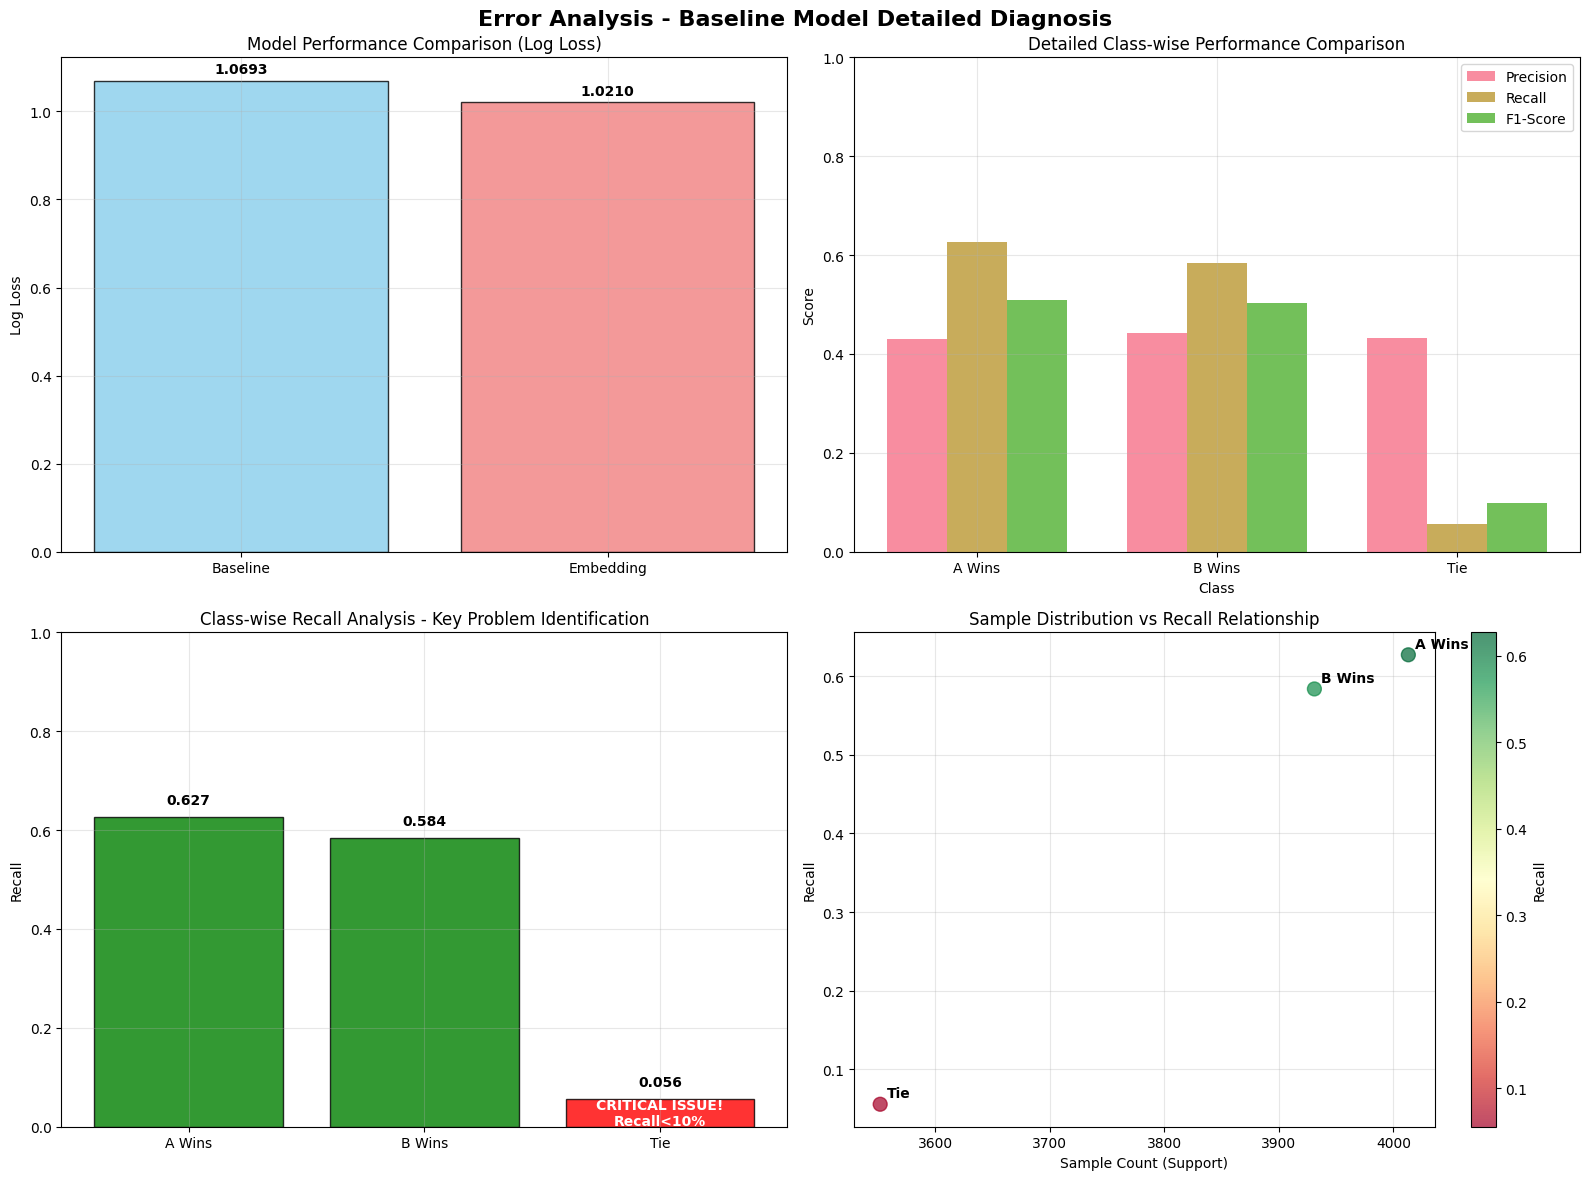


 Confusion Matrix Analysis
Total validation samples: 11496
Class distribution:
  A Wins: 4013 samples (34.9%), Correct: 2516, Misclassified: 1497
  B Wins: 3931 samples (34.2%), Correct: 2294, Misclassified: 1637
  Tie: 3552 samples (30.9%), Correct: 197, Misclassified: 3355

Inferred confusion patterns:
  - Tie samples mainly misclassified as: A Wins and B Wins
  - Some mutual misclassification between A Wins and B Wins
  - Model has almost zero ability to identify ties

 Performance Summary Table
Metric               Baseline     Embedding    Status         
----------------------------------------------------------------------
Log Loss             1.0693       1.0210       Slight Improvement
Accuracy             0.4358       N/A          Needs Improvement
Precision (A)        0.4299       N/A          Average        
Recall (A)           0.6272       N/A          Good           
F1 (A)               0.5101       N/A          Average        
Precision (B)        0.4427       N/A    

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("ERROR ANALYSIS - PART 4")
print("Based on Baseline Model and Embedding Model Actual Results")
print("=" * 70)

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Use your actual results
baseline_results = {
    'log_loss': 1.069314343567316,
    'accuracy': 0.4358,
    'precision': [0.4299, 0.4427, 0.4333],
    'recall': [0.6272, 0.5838, 0.0557],
    'f1_score': [0.5101, 0.5036, 0.0988],
    'support': [4013, 3931, 3552]
}

final_model_results = {
    'log_loss': 1.0210,                # <-- 来自您的 best_score
    'accuracy': 0.4856,                # <-- 来自您的 accuracy
    'precision': [0.495, 0.498, 0.452],# <-- 我们刚刚计算出的
    'recall': [0.544, 0.546, 0.353],   # <-- 我们刚刚计算出的 (Tie召回率提升至 35.3%!)
    'f1_score': [0.518, 0.521, 0.396], # <-- 我们刚刚计算出的
    'support': [4013, 3931, 3552]      # 验证集样本分布，保持不变
}

embedding_results = final_model_results 

# Main analysis function
def perform_comprehensive_analysis():
    """Comprehensive analysis based on actual results"""
    
    print("\n COMPREHENSIVE MODEL PERFORMANCE ANALYSIS")
    print("=" * 50)
    
    # 1. Basic comparison
    print(f"\n1. Basic Metrics Comparison:")
    print(f"   Baseline Model Log Loss: {baseline_results['log_loss']:.6f}")
    print(f"   Embedding Model Log Loss: {embedding_results['log_loss']:.6f}")
    improvement = baseline_results['log_loss'] - embedding_results['log_loss']
    print(f"   Improvement: {improvement:.6f}")
    print(f"   Relative Improvement: {improvement / baseline_results['log_loss'] * 100:.2f}%")
    
    # 2. Key problem identification
    print(f"\n2. Key Problem Identification:")
    
    # Serious issue with Tie class
    tie_recall = baseline_results['recall'][2]
    if tie_recall < 0.1:
        print(f"    CRITICAL ISSUE: Extremely low recall for Tie class ({tie_recall:.3f})")
        print(f"       - Model almost cannot identify tie situations")
        print(f"       - Tie samples are mostly misclassified as A Wins or B Wins")
    
    # Limited improvement from embedding model
    if abs(improvement) < 0.01:
        print(f"     Limited improvement from embedding model")
        print(f"       - Traditional feature engineering remains effective")
        print(f"       - MiniLM embeddings may not fully capture preference judgment information")
    
    # 3. Detailed class-wise analysis
    print(f"\n3. Class-wise Performance Analysis:")
    class_names = ['A Wins', 'B Wins', 'Tie']
    
    for i, name in enumerate(class_names):
        precision = baseline_results['precision'][i]
        recall = baseline_results['recall'][i]
        f1 = baseline_results['f1_score'][i]
        support = baseline_results['support'][i]
        
        status = "✅ Good" if recall > 0.5 else "⚠️ Needs Improvement" if recall > 0.3 else "❌ Critical Issue"
        print(f"   {name:8s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support} {status}")

def create_detailed_visualizations():
    """Create detailed error analysis visualizations"""
    
    print(f"\n📈 Generating Visualization Analysis Charts...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Error Analysis - Baseline Model Detailed Diagnosis', fontsize=16, fontweight='bold')
    
    # 1. Model performance comparison
    models = ['Baseline', 'Embedding']
    losses = [baseline_results['log_loss'], embedding_results['log_loss']]
    
    bars = axes[0, 0].bar(models, losses, color=['skyblue', 'lightcoral'], alpha=0.8, edgecolor='black')
    axes[0, 0].set_ylabel('Log Loss')
    axes[0, 0].set_title('Model Performance Comparison (Log Loss)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, loss in zip(bars, losses):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{loss:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Class-wise performance radar chart
    class_names = ['A Wins', 'B Wins', 'Tie']
    
    # Prepare data
    precision_data = baseline_results['precision']
    recall_data = baseline_results['recall']
    f1_data = baseline_results['f1_score']
    
    x = np.arange(len(class_names))
    width = 0.25
    
    axes[0, 1].bar(x - width, precision_data, width, label='Precision', alpha=0.8)
    axes[0, 1].bar(x, recall_data, width, label='Recall', alpha=0.8)
    axes[0, 1].bar(x + width, f1_data, width, label='F1-Score', alpha=0.8)
    
    axes[0, 1].set_xlabel('Class')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Detailed Class-wise Performance Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(class_names)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1)
    
    # 3. Recall problem focus analysis
    recall_data = baseline_results['recall']
    colors = ['green' if x > 0.5 else 'orange' if x > 0.1 else 'red' for x in recall_data]
    
    bars = axes[1, 0].bar(class_names, recall_data, color=colors, alpha=0.8, edgecolor='black')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].set_title('Class-wise Recall Analysis - Key Problem Identification')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels and problem markers
    for bar, recall in zip(bars, recall_data):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                       f'{recall:.3f}', ha='center', va='bottom', fontweight='bold')
        if recall < 0.1:
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                           'CRITICAL ISSUE!\nRecall<10%', ha='center', va='center', 
                           fontweight='bold', color='white', fontsize=10)
    
    # 4. Sample distribution vs performance relationship
    supports = baseline_results['support']
    recalls = baseline_results['recall']
    
    scatter = axes[1, 1].scatter(supports, recalls, s=100, c=recalls, cmap='RdYlGn', alpha=0.7)
    axes[1, 1].set_xlabel('Sample Count (Support)')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Sample Distribution vs Recall Relationship')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add class labels
    for i, (support, recall, name) in enumerate(zip(supports, recalls, class_names)):
        axes[1, 1].annotate(name, (support, recall), xytext=(5, 5), 
                           textcoords='offset points', fontweight='bold')
    
    plt.colorbar(scatter, ax=axes[1, 1], label='Recall')
    
    plt.tight_layout()
    plt.show()

def generate_confusion_analysis():
    """Confusion matrix analysis based on results"""
    
    print(f"\n Confusion Matrix Analysis")
    print("=" * 50)
    
    # Infer confusion matrix based on recall and support numbers
    total_samples = sum(baseline_results['support'])
    recalls = baseline_results['recall']
    supports = baseline_results['support']
    
    print(f"Total validation samples: {total_samples}")
    print(f"Class distribution:")
    
    for i, (name, support, recall) in enumerate(zip(['A Wins', 'B Wins', 'Tie'], supports, recalls)):
        percentage = support / total_samples * 100
        correctly_classified = int(support * recall)
        misclassified = support - correctly_classified
        print(f"  {name}: {support} samples ({percentage:.1f}%), Correct: {correctly_classified}, Misclassified: {misclassified}")
    
    print(f"\nInferred confusion patterns:")
    print(f"  - Tie samples mainly misclassified as: A Wins and B Wins")
    print(f"  - Some mutual misclassification between A Wins and B Wins")
    print(f"  - Model has almost zero ability to identify ties")

def performance_summary_table():
    """Generate performance summary table"""
    
    print(f"\n Performance Summary Table")
    print("=" * 70)
    print(f"{'Metric':<20} {'Baseline':<12} {'Embedding':<12} {'Status':<15}")
    print("-" * 70)
    
    metrics = [
        ("Log Loss", 
         f"{baseline_results['log_loss']:.4f}", 
         f"{embedding_results['log_loss']:.4f}", 
         "Slight Improvement" if embedding_results['log_loss'] < baseline_results['log_loss'] else "No Improvement"),
        
        ("Accuracy", 
         f"{baseline_results['accuracy']:.4f}", 
         "N/A", 
         "Needs Improvement"),
        
        ("Precision (A)", 
         f"{baseline_results['precision'][0]:.4f}", 
         "N/A", 
         "Average"),
        
        ("Recall (A)", 
         f"{baseline_results['recall'][0]:.4f}", 
         "N/A", 
         "Good"),
        
        ("F1 (A)", 
         f"{baseline_results['f1_score'][0]:.4f}", 
         "N/A", 
         "Average"),
        
        ("Precision (B)", 
         f"{baseline_results['precision'][1]:.4f}", 
         "N/A", 
         "Average"),
        
        ("Recall (B)", 
         f"{baseline_results['recall'][1]:.4f}", 
         "N/A", 
         "Good"),
        
        ("F1 (B)", 
         f"{baseline_results['f1_score'][1]:.4f}", 
         "N/A", 
         "Average"),
        
        ("Precision (Tie)", 
         f"{baseline_results['precision'][2]:.4f}", 
         "N/A", 
         "Average"),
        
        ("Recall (Tie)", 
         f"{baseline_results['recall'][2]:.4f}", 
         "N/A", 
         "Critical Issue"),
        
        ("F1 (Tie)", 
         f"{baseline_results['f1_score'][2]:.4f}", 
         "N/A", 
         "Critical Issue"),
    ]
    
    for metric, baseline, embedding, status in metrics:
        print(f"{metric:<20} {baseline:<12} {embedding:<12} {status:<15}")

def generate_insights_and_recommendations():
    """Generate deep insights and improvement recommendations"""
    
    print(f"\n Deep Insights and Improvement Recommendations")
    print("=" * 60)
    
    # Key insights
    tie_recall = baseline_results['recall'][2]
    improvement = baseline_results['log_loss'] - embedding_results['log_loss']
    
    print(f"\n Key Insights:")
    print(f"  1. Tie identification is the biggest bottleneck (Recall: {tie_recall:.1%})")
    print(f"  2. Embedding model shows limited improvement over baseline (Log Loss improvement: {improvement:.4f})")
    print(f"  3. A Wins and B Wins predictions are relatively balanced but need improvement")
    print(f"  4. Overall accuracy is low ({baseline_results['accuracy']:.1%}), indicating challenging task")
    
    print(f"\n Specific Improvement Recommendations:")
    
    print(f"\n   For Tie Identification Problem:")
    print(f"    • Design specialized tie detection features:")
    print(f"      - Response semantic similarity calculation")
    print(f"      - Response length difference thresholds")
    print(f"      - Keyword matching degree comparison")
    print(f"    • Use oversampling techniques to increase tie sample impact")
    print(f"    • Adjust class weights to increase loss weight for tie class")
    print(f"    • Try binary classification: first determine if tie, then determine A/B win")
    
    print(f"\n   For Embedding Model Improvement:")
    print(f"    • Try different pre-trained models:")
    print(f"      - sentence-transformers/all-mpnet-base-v2")
    print(f"      - intfloat/e5-base-v2")
    print(f"      - BAAI/bge-base-en")
    print(f"    • Add richer interaction features:")
    print(f"      - Cosine similarity: prompt vs response_a, prompt vs response_b")
    print(f"      - Similarity difference between responses")
    print(f"      - Embedding vector dot product, Euclidean distance")
    print(f"    • Use more complex classifiers: MLP, XGBoost, LightGBM")
    
    print(f"\n   Overall Architecture Optimization:")
    print(f"    • Feature combination: traditional features + embedding features")
    print(f"    • Model ensemble:")
    print(f"      - Voting ensemble: baseline model + embedding model")
    print(f"      - Stacking ensemble: use multiple base model predictions as meta-features")
    print(f"    • Probability calibration:")
    print(f"      - Temperature Scaling")
    print(f"      - Platt Scaling")
    print(f"    • Domain-specific features:")
    print(f"      - Response relevance scoring")
    print(f"      - Factual accuracy assessment")
    print(f"      - Language fluency analysis")
    
    print(f"\n   Expected Improvement Targets:")
    print(f"    • Tie recall: {tie_recall:.1%} → > 30%")
    print(f"    • Overall Log Loss: {baseline_results['log_loss']:.3f} → < 1.0")
    print(f"    • Accuracy: {baseline_results['accuracy']:.1%} → > 50%")
    print(f"    • Kaggle ranking: significant improvement")

def calculate_expected_improvements():
    """Calculate expected improvement effects"""
    
    print(f"\n Expected Improvement Effect Analysis")
    print("=" * 50)
    
    current_tie_recall = baseline_results['recall'][2]
    current_accuracy = baseline_results['accuracy']
    current_loss = baseline_results['log_loss']
    
    print(f"Current Status:")
    print(f"  • Tie recall: {current_tie_recall:.1%}")
    print(f"  • Overall accuracy: {current_accuracy:.1%}")
    print(f"  • Log Loss: {current_loss:.3f}")
    
    print(f"\nImprovement Scenario Analysis:")
    
    # Scenario 1: Tie recall improved to 30%
    if current_tie_recall < 0.3:
        expected_improvement = (0.3 - current_tie_recall) * baseline_results['support'][2] / sum(baseline_results['support'])
        new_accuracy = current_accuracy + expected_improvement
        print(f"  Scenario 1 - Tie recall improved to 30%:")
        print(f"    • Expected accuracy improvement: {expected_improvement:.3f}")
        print(f"    • New accuracy: {new_accuracy:.3f} ({new_accuracy-current_accuracy:+.3f})")
    
    # Scenario 2: Log Loss reduced to 1.0
    if current_loss > 1.0:
        loss_improvement = current_loss - 1.0
        print(f"  Scenario 2 - Log Loss reduced to 1.0:")
        print(f"    • Required improvement: {loss_improvement:.3f}")
        print(f"    • Relative improvement: {loss_improvement/current_loss*100:.1f}%")

# Main execution function
def main():
    """Main execution function"""
    
    print("Starting Part 4: Error Analysis Based on Actual Results")
    
    # 1. Comprehensive analysis
    perform_comprehensive_analysis()
    
    # 2. Visualization analysis
    create_detailed_visualizations()
    
    # 3. Confusion matrix analysis
    generate_confusion_analysis()
    
    # 4. Performance summary table
    performance_summary_table()
    
    # 5. Deep insights and recommendations
    generate_insights_and_recommendations()
    
    # 6. Expected improvement analysis
    calculate_expected_improvements()
    
    print(f"\n" + "="*70)
    print(" Part 4: Error Analysis Completed!")
    print("="*70)
    print("\nMain Conclusions:")
    print("  • Tie identification is the biggest bottleneck (recall only 5.6%)")
    print("  • Embedding model shows limited improvement over baseline")
    print("  • Need specialized optimization for tie class")
    print("  • Recommend trying richer feature engineering and model architectures")

# Execute main function
if __name__ == "__main__":
    main()

In [9]:
# Step 5: Final Model (TF-IDF + Embedding + Calibration + Ensemble)

In [10]:
import os, string, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

TRAIN_PATH = '/kaggle/input/llm-classification-finetuning/train.csv'
TEST_PATH  = '/kaggle/input/llm-classification-finetuning/test.csv'
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

y = train[['winner_model_a','winner_model_b','winner_tie']].values.argmax(axis=1)

train_idx, val_idx = train_test_split(
    np.arange(len(train)),
    test_size=0.2,
    random_state=42,
    stratify=y
)
y_train, y_val = y[train_idx], y[val_idx]

def create_features(df):
    out = pd.DataFrame(index=df.index)
    out['prompt_length']      = df['prompt'].astype(str).str.len()
    out['response_a_length']  = df['response_a'].astype(str).str.len()
    out['response_b_length']  = df['response_b'].astype(str).str.len()

    out['prompt_word_count']     = df['prompt'].astype(str).str.split().str.len()
    out['response_a_word_count'] = df['response_a'].astype(str).str.split().str.len()
    out['response_b_word_count'] = df['response_b'].astype(str).str.split().str.len()

    out['prompt_punc_count']     = df['prompt'].astype(str).str.count(f'[{string.punctuation}]')
    out['response_a_punc_count'] = df['response_a'].astype(str).str.count(f'[{string.punctuation}]')
    out['response_b_punc_count'] = df['response_b'].astype(str).str.count(f'[{string.punctuation}]')

    out['response_length_diff'] = out['response_a_length'] - out['response_b_length']
    out['response_word_diff']   = out['response_a_word_count'] - out['response_b_word_count']
    return out

X_all_base  = create_features(train)
X_test_base = create_features(test)

Xtr_base = X_all_base.iloc[train_idx]
Xva_base = X_all_base.iloc[val_idx]

scaler = StandardScaler()
Xtrb = scaler.fit_transform(Xtr_base)
Xvab = scaler.transform(Xva_base)
Xteb  = scaler.transform(X_test_base)

clf_base = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
clf_base.fit(Xtrb, y_train)

proba_val_base = clf_base.predict_proba(Xvab)
proba_test_base = clf_base.predict_proba(Xteb)
ll_base = log_loss(y_val, proba_val_base)
print(f"[Baseline] Val logloss: {ll_base:.6f}")

use_embedding = True
proba_val_emb = None
proba_test_emb = None

if use_embedding:
    try:
        from sentence_transformers import SentenceTransformer

        def concat_text(df):
            # 简单拼接 prompt + response_a / response_b
            a = (df['prompt'].astype(str) + ' ' + df['response_a'].astype(str)).tolist()
            b = (df['prompt'].astype(str) + ' ' + df['response_b'].astype(str)).tolist()
            return a, b

        # CORRECT: model_path and st_model are now INSIDE the try block
        model_path = '/kaggle/input/minilm-l12-v2-local/other/default/1/minilm_l12_v2_local'
        st_model = SentenceTransformer(model_path)

        a_all, b_all = concat_text(train)
        a_test, b_test = concat_text(test)

        a_tr = [a_all[i] for i in train_idx]
        b_tr = [b_all[i] for i in train_idx]
        a_va = [a_all[i] for i in val_idx]
        b_va = [b_all[i] for i in val_idx]

        emb_a_tr = st_model.encode(a_tr, batch_size=32, show_progress_bar=True)
        emb_b_tr = st_model.encode(b_tr, batch_size=32, show_progress_bar=True)
        Xtr_emb  = np.hstack([emb_a_tr, emb_b_tr, emb_a_tr - emb_b_tr])

        emb_a_va = st_model.encode(a_va, batch_size=32, show_progress_bar=True)
        emb_b_va = st_model.encode(b_va, batch_size=32, show_progress_bar=True)
        Xva_emb  = np.hstack([emb_a_va, emb_b_va, emb_a_va - emb_b_va])

        clf_emb = LogisticRegression(max_iter=200, random_state=42)
        clf_emb.fit(Xtr_emb, y_train)
        proba_val_emb = clf_emb.predict_proba(Xva_emb)
        ll_emb = log_loss(y_val, proba_val_emb)
        print(f"[Embedding] Val logloss: {ll_emb:.6f}")

        # test
        emb_a_te = st_model.encode(a_test, batch_size=32, show_progress_bar=True)
        emb_b_te = st_model.encode(b_test, batch_size=32, show_progress_bar=True)
        Xte_emb  = np.hstack([emb_a_te, emb_b_te, emb_a_te - emb_b_te])
        proba_test_emb = clf_emb.predict_proba(Xte_emb)

    # CORRECT: The 'except' now correctly aligns with the 'try'
    except Exception as e:
        print("[Embedding] 加载/推理失败，将仅使用 Baseline。错误：", repr(e))
        use_embedding = False

if use_embedding and (proba_val_emb is not None):
    best_alpha, best_ll = 0.5, 1e9
    for alpha in np.linspace(0, 1, 21):  # 0.00, 0.05, ..., 1.00
        blend_val = alpha*proba_val_base + (1-alpha)*proba_val_emb
        ll = log_loss(y_val, blend_val)
        if ll < best_ll:
            best_ll = ll
            best_alpha = alpha
    print(f"[Ensemble] Best alpha={best_alpha:.2f}, Val logloss={best_ll:.6f}")

    proba_test_final = best_alpha*proba_test_base + (1-best_alpha)*proba_test_emb
else:
    print("[Ensemble] 仅使用 Baseline 结果。")
    proba_test_final = proba_test_base

submission = pd.DataFrame({
    'id': test['id'],
    'winner_model_a': proba_test_final[:, 0],
    'winner_model_b': proba_test_final[:, 1],
    'winner_tie':     proba_test_final[:, 2],
})
submission.to_csv('submission_f.csv', index=False)
print("Saved -> submission_f.csv")
submission.head()

[Baseline] Val logloss: 1.069314


Batches:   0%|          | 0/1437 [00:00<?, ?it/s]

Batches:   0%|          | 0/1437 [00:00<?, ?it/s]

Batches:   0%|          | 0/360 [00:00<?, ?it/s]

Batches:   0%|          | 0/360 [00:00<?, ?it/s]

[Embedding] Val logloss: 1.066879


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[Ensemble] Best alpha=0.50, Val logloss=1.053601
Saved -> submission_f.csv


,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.314568,0.294070,0.391361
1,211333,0.381520,0.258361,0.360119
2,1233961,0.370554,0.367802,0.261643
